In [3]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

# Quantum Algorithms I

## Concepts & Techniques
### Operators
Quantum gates are represented by operators. Operators a unitary matrices.

In [4]:
from qiskit.circuit.library import HGate, ZGate, XGate

More gates can be found at https://qiskit.org/documentation/apidoc/circuit_library.html

In [5]:
XGate().to_matrix()

array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])

In [4]:
ZGate().to_matrix()

array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])

In [5]:
HGate().to_matrix()

array([[ 0.70710678+0.j,  0.70710678+0.j],
       [ 0.70710678+0.j, -0.70710678+0.j]])

Matrices represents linear transformations, mapping each basis with a row.

In [6]:
import numpy as np
basis = [1, 0]
HGate().to_matrix() * np.array([basis])

array([[ 0.70710678+0.j,  0.        +0.j],
       [ 0.70710678+0.j, -0.        +0.j]])

### Phase kick-back
A technique for transmitting a phase offset to a quantum state.

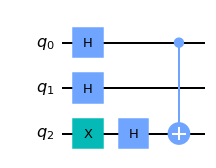

In [9]:
def phase_kick_back(circuit, bit_idx):
    '''Returns a new circuit with phase kick-back piece attached at `bit_idx`.'''
    num_qubits, num_clbits = circuit.num_qubits, circuit.num_clbits
    if not num_clbits:
        extension = QuantumCircuit(num_qubits)
    else:
        extension = QuantumCircuit(num_qubits, num_clbits)
    extension.x(bit_idx)
    extension.h(bit_idx)
    return extension + circuit

kick_back_circuit = QuantumCircuit(3)
kick_back_circuit.h([0, 1])
kick_back_circuit.cx(0, 2)
kick_back_circuit = phase_kick_back(kick_back_circuit, 2)
kick_back_circuit.draw('mpl')

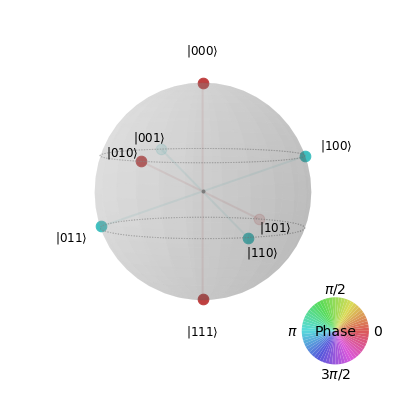

In [8]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere
plot_state_qsphere(Statevector.from_instruction(kick_back_circuit))

### Oracles
Amplitude oracles are circuits computing $|x\rangle|y\rangle\rightarrow|x\rangle|y \oplus f(x)\rangle$.

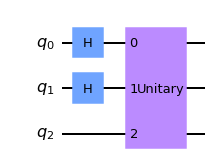

In [9]:
import numpy as np
import qiskit.quantum_info as qi
u_and = qi.Operator(np.array([
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
]))
amplitude_oracle_circuit = QuantumCircuit(3)
amplitude_oracle_circuit.h([0, 1])
amplitude_oracle_circuit.append(u_and, [0, 1, 2])
amplitude_oracle_circuit.draw()

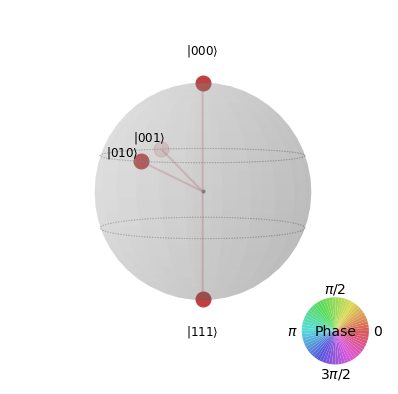

In [10]:
from qiskit.visualization import plot_state_qsphere
plot_state_qsphere(qi.Statevector.from_instruction(amplitude_oracle_circuit))

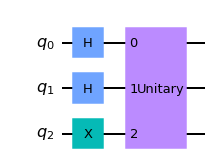

In [11]:
compl_amplitude_oracle_circuit = QuantumCircuit(3)
compl_amplitude_oracle_circuit.h([0, 1])
compl_amplitude_oracle_circuit.x(2)
compl_amplitude_oracle_circuit.append(u_and, [0, 1, 2])
compl_amplitude_oracle_circuit.draw()

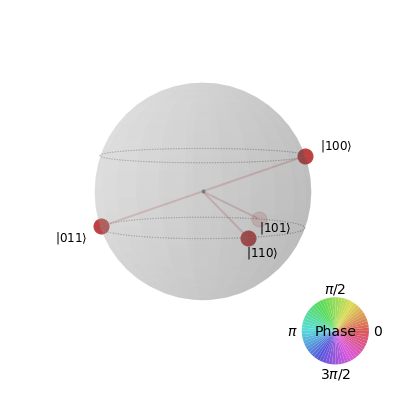

In [12]:
plot_state_qsphere(qi.Statevector.from_instruction(compl_amplitude_oracle_circuit))

Phase oracles are circuits computing $|x\rangle\rightarrow(-1)^{f(x)}|x\rangle$.

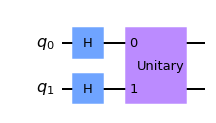

In [13]:
phase_u_and = qi.Operator(np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, -1]
]))
phase_oracle_circuit = QuantumCircuit(2)
phase_oracle_circuit.h([0, 1])
phase_oracle_circuit.append(phase_u_and, [0, 1])
phase_oracle_circuit.draw()

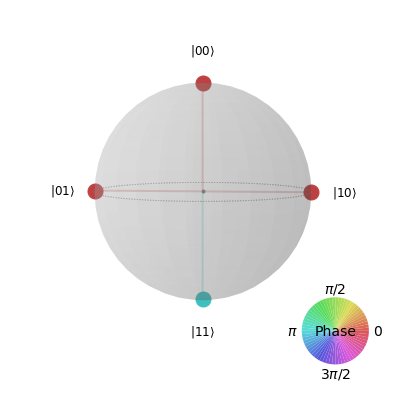

In [14]:
plot_state_qsphere(qi.Statevector.from_instruction(phase_oracle_circuit))

### Hadamard Operator
Change the basis from $Z$ to $X$. It can be seen as a mapping between $Z$ computational basis and different kind of phase distributions.

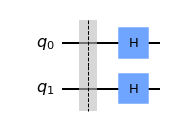

In [15]:
hadamard_circuit_00 = QuantumCircuit(2)
hadamard_circuit_00.barrier()
hadamard_circuit_00.h([0, 1])
hadamard_circuit_00.draw()

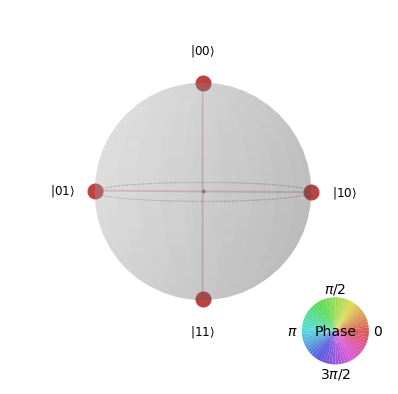

In [16]:
plot_state_qsphere(qi.Statevector.from_instruction(hadamard_circuit_00))

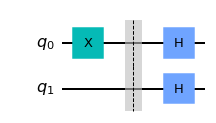

In [17]:
hadamard_circuit_01 = QuantumCircuit(2)
hadamard_circuit_01.x(0)
hadamard_circuit_01.barrier()
hadamard_circuit_01.h([0, 1])
hadamard_circuit_01.draw()

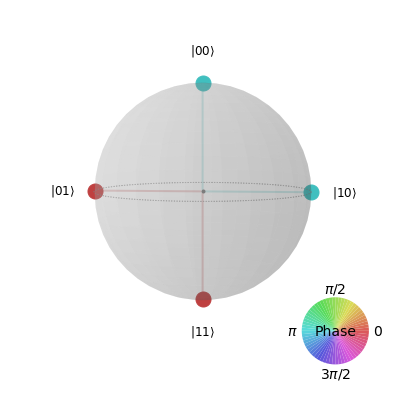

In [18]:
plot_state_qsphere(qi.Statevector.from_instruction(hadamard_circuit_01))

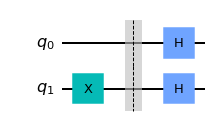

In [19]:
hadamard_circuit_10 = QuantumCircuit(2)
hadamard_circuit_10.x(1)
hadamard_circuit_10.barrier()
hadamard_circuit_10.h([0, 1])
hadamard_circuit_10.draw()

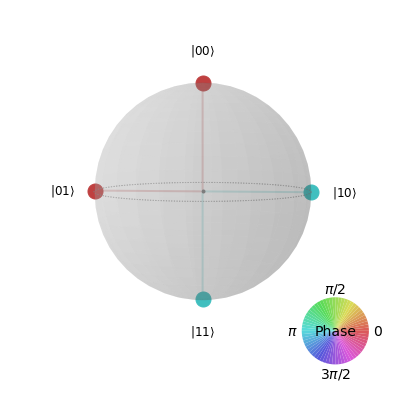

In [20]:
plot_state_qsphere(qi.Statevector.from_instruction(hadamard_circuit_10))

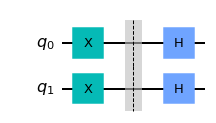

In [21]:
hadamard_circuit_11 = QuantumCircuit(2)
hadamard_circuit_11.x([0,1])
hadamard_circuit_11.barrier()
hadamard_circuit_11.h([0, 1])
hadamard_circuit_11.draw()

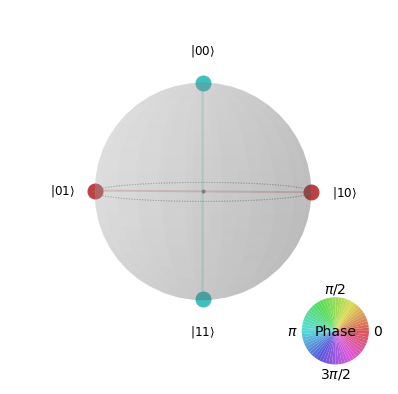

In [22]:
plot_state_qsphere(qi.Statevector.from_instruction(hadamard_circuit_11))

Each distribution of phases is a basis in $X$. Measuring in $X$ consists in applying the inverse of the basis and then measuring. Turns out $H$ is its own inverse.

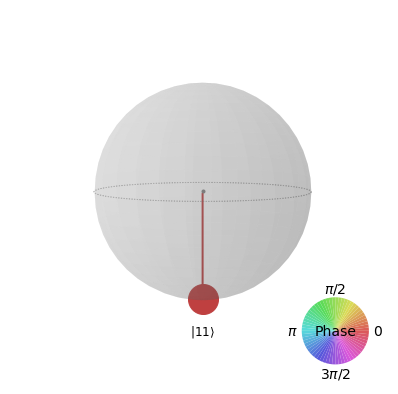

In [23]:
def x_to_z(circuit, qubit_indices):
    '''Return a new circuit with a basis change attached to the qubits in `qubit_indices`. '''
    num_qubits, num_clbits = circuit.num_qubits, circuit.num_clbits
    if not num_clbits:
        extension = QuantumCircuit(num_qubits)
    else:
        extension = QuantumCircuit(num_qubits, num_clbits)
        
    extension.h(qubit_indices)
    return circuit + extension

import random
hadamard_basis_circuits = [hadamard_circuit_00, hadamard_circuit_01, hadamard_circuit_10, hadamard_circuit_11]
random_basis = random.choice(hadamard_basis_circuits)
random_pick_in_x_basis = x_to_z(random_basis, [0,1])
plot_state_qsphere(qi.Statevector.from_instruction(random_pick_in_x_basis))

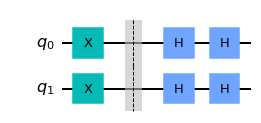

In [24]:
random_pick_in_x_basis.draw()

Changing the amplitude distribution in the $Z$ basis is equivalent to change the phase distribution in the $X$ basis.

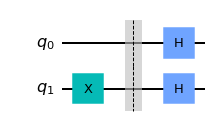

In [25]:
change_amplitude_circuit = QuantumCircuit(2)
change_amplitude_circuit.x(1)
change_amplitude_circuit.barrier()
change_amplitude_circuit.h([0, 1])
change_amplitude_circuit.draw()

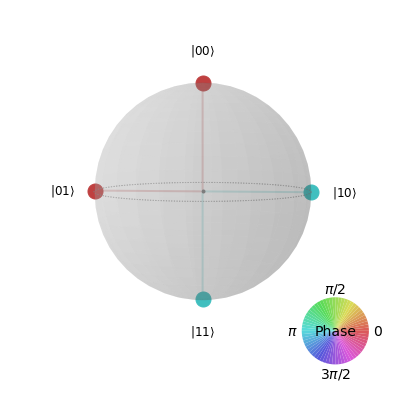

In [26]:
plot_state_qsphere(qi.Statevector.from_instruction(change_amplitude_circuit))

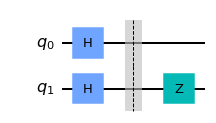

In [27]:
change_phase_circuit = QuantumCircuit(2)
change_phase_circuit.h([0, 1])
change_phase_circuit.barrier()
change_phase_circuit.z(1)
change_phase_circuit.draw()

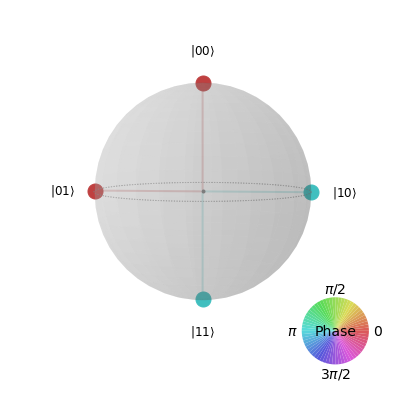

In [28]:
plot_state_qsphere(qi.Statevector.from_instruction(change_phase_circuit))

## Deutsch-Jozsa
Determine if a hidden Boolean function is constant or balanced. The function is promised to be one of these.

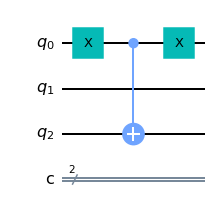

In [29]:
import random
def flip_coin():
    return bool(random.randrange(2))

def get_dj_orcale(num_inputs):
    '''Return an amplitude oracle for a constant/balanced function, randomly.'''
    n = num_inputs + 1
    circuit = QuantumCircuit(n, name='DJ Function')
    is_constant = flip_coin()
    if is_constant:
        is_zero = flip_coin()
        if not is_zero:
            circuit.x(n-1)

    if not is_constant:
        for idx in range(n-1):
            is_contributing_to_result = flip_coin()
            if is_contributing_to_result:
                is_negated = flip_coin()
                
                if is_negated:
                    circuit.x(idx)
                    
                circuit.cx(idx, n-1)
                
                if is_negated:
                    circuit.x(idx)

    return circuit.to_gate()

n = 2
random_dj_oracle = get_dj_orcale(n)
dj_circuit = QuantumCircuit(n + 1, n)
dj_circuit.append(random_dj_oracle, range(n+1))
dj_circuit = dj_circuit.decompose()
dj_circuit.draw()

By feeding an homogenoues **superposition** in the inputs we can observe the values where the function has a valid value.

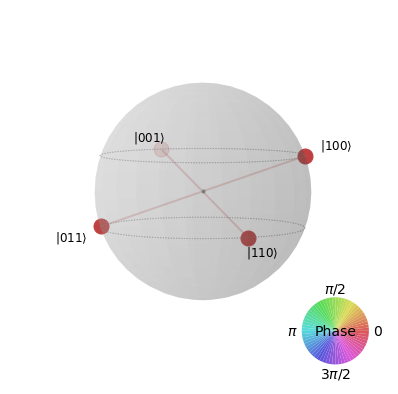

In [30]:
def superposition(circuit, qubit_indices):
    '''Return a new circuit feeding an homogeneous superposition to the `circuit` at `qubit_indices`. '''
    num_qubits, num_clbits = circuit.num_qubits, circuit.num_clbits
    if not num_clbits:
        extension = QuantumCircuit(num_qubits)
    else:
        extension = QuantumCircuit(num_qubits, num_clbits)
        
    extension.h(qubit_indices)
    return extension + circuit

dj_circuit = superposition(dj_circuit, range(n))
plot_state_qsphere(qi.Statevector.from_instruction(dj_circuit))

The **kick-back** trick introduces a phase difference of $180°$ between the valid and invalid solution. Only when there are CNOT gates in the oracle!

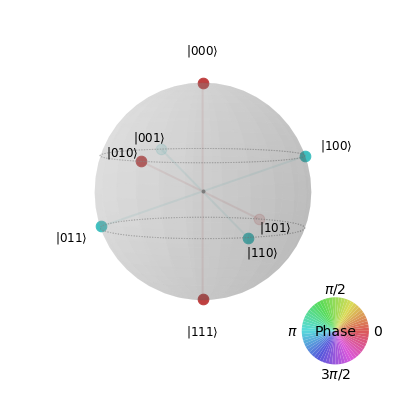

In [31]:
initialized_dj_circuit = phase_kick_back(dj_circuit, n)
plot_state_qsphere(qi.Statevector.from_instruction(initialized_dj_circuit))

Upon the base change, only in the absence of CNOT gates, it will map to the $|0\rangle$ state.

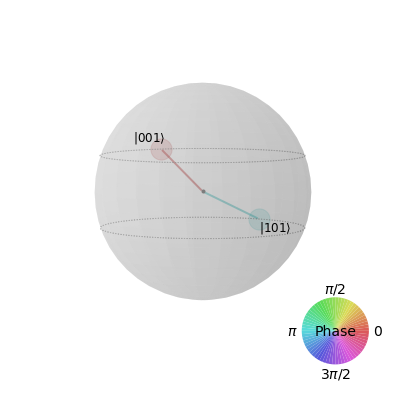

In [32]:
finalized_dj_circuit = x_to_z(initialized_dj_circuit, range(n))
plot_state_qsphere(qi.Statevector.from_instruction(finalized_dj_circuit))

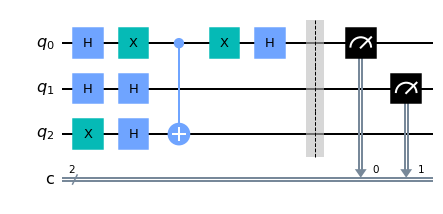

In [33]:
dj_circuit_with_measurement = finalized_dj_circuit.copy()
dj_circuit_with_measurement.barrier()
dj_circuit_with_measurement.measure(range(n), range(n))
dj_circuit_with_measurement.draw()

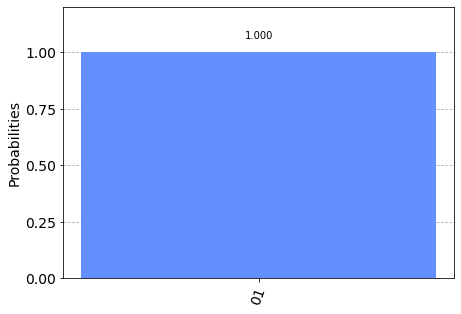

In [34]:
from qiskit import BasicAer
backend = BasicAer.get_backend('qasm_simulator')
result = execute(dj_circuit_with_measurement, backend=backend).result()
plot_histogram(result.get_counts())

## Bernstein-Vazirani
Given a function computing the dot product (mod 2) of the input and a hidden bit-string, guess the hidden bit-string.

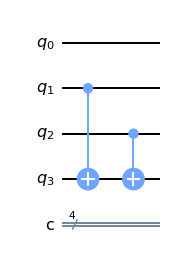

In [35]:
def get_bv_oracle(num_inputs):
    '''Return an amplitude oracle for a dot product (mod 2) function, random.'''
    n = num_inputs + 1
    circuit = QuantumCircuit(n)
    secret_bitstring = bin(random.randrange(2**num_inputs))[2:].zfill(num_inputs)
    for idx, a_bit in enumerate(reversed(secret_bitstring)):
        if a_bit == '1':
            circuit.cx(idx, n-1)
    gate = circuit.to_gate()
    gate._secret_bitstring = secret_bitstring
    return gate

n = 3
random_bv_oracle = get_bv_oracle(n)
bv_circuit = QuantumCircuit(n + 1, n + 1)
bv_circuit.append(random_bv_oracle, range(n+1))
bv_circuit = bv_circuit.decompose()
bv_circuit.draw()

**Superposition**:

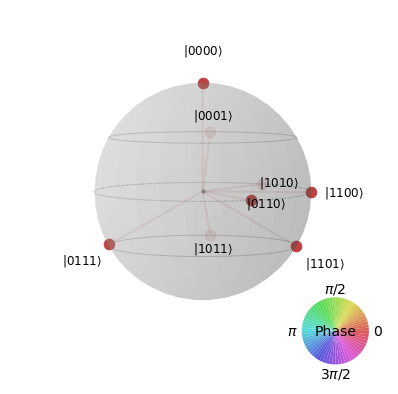

In [36]:
bv_circuit_with_superposition = superposition(bv_circuit, range(n))
plot_state_qsphere(qi.Statevector.from_instruction(bv_circuit_with_superposition))

**Phase kick-back**:

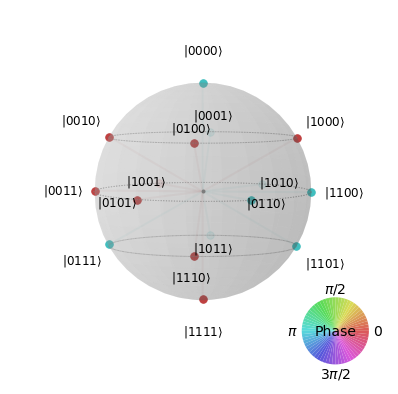

In [37]:
initialized_bv_circuit = phase_kick_back(bv_circuit_with_superposition, n)
plot_state_qsphere(qi.Statevector.from_instruction(initialized_bv_circuit))

**Basis change**:

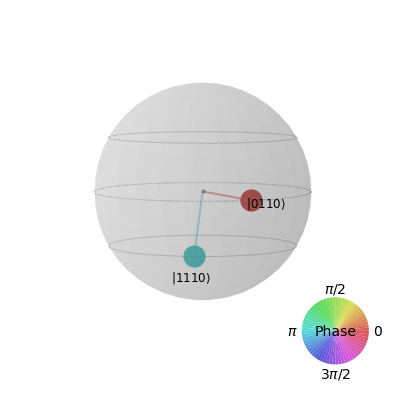

In [38]:
finalized_bv_circuit = x_to_z(initialized_bv_circuit, range(n))
plot_state_qsphere(qi.Statevector.from_instruction(finalized_bv_circuit))

**Measurement**:

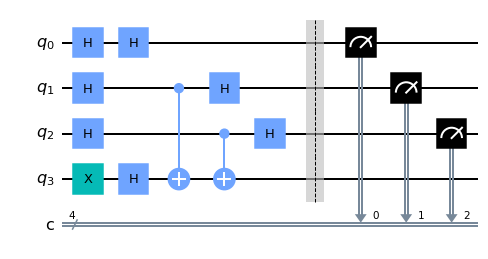

In [39]:
bv_circuit_with_measurement = finalized_bv_circuit.copy()
bv_circuit_with_measurement.barrier()
bv_circuit_with_measurement.measure(range(n), range(n))
bv_circuit_with_measurement.draw()

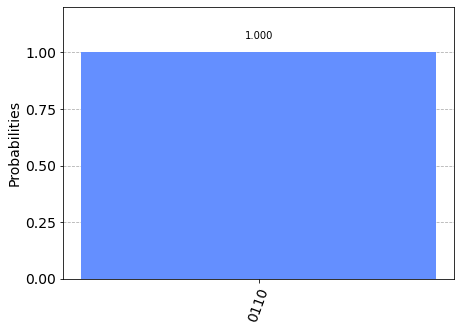

In [40]:
result = execute(bv_circuit_with_measurement, backend=backend).result()
plot_histogram(result.get_counts())

In [41]:
random_bv_oracle._secret_bitstring

'110'

## Grover
What number is `101`, after a left rotation?

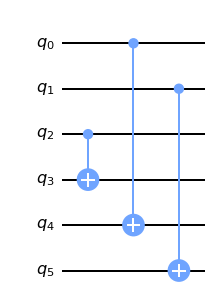

In [42]:
def get_left_rotation(width):
    circuit = QuantumCircuit(2*width, name=f'{width}-bit rotation')
    for idx in range(width):
        circuit.cx(idx, width + ((idx + 1) % width))
    return circuit.to_gate()

n = 3
left_rotation = get_left_rotation(n)
rotation_circuit = QuantumCircuit(left_rotation.num_qubits, name='Grover Oracle')
rotation_circuit.append(left_rotation, range(left_rotation.num_qubits))
rotation_circuit = rotation_circuit.decompose()
rotation_circuit.draw()

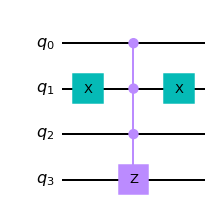

In [43]:
def recognize(target):
    num_qubits = len(target) + 1
    mcz = ZGate().control(len(target))
    circuit = QuantumCircuit(num_qubits, name=f'input == {target}')
    for idx, a_bit in enumerate(reversed(target)):
        if a_bit == '0':
            circuit.x(idx)
            
    circuit.append(mcz, list(range(num_qubits)))
        
    for idx, a_bit in enumerate(reversed(target)):
        if a_bit == '0':
            circuit.x(idx)
            
    return circuit.to_gate()

target = '101'
comparator = recognize(target)
comparator_circuit = QuantumCircuit(comparator.num_qubits)
comparator_circuit.append(comparator, range(comparator.num_qubits))
comparator_circuit.decompose().draw()

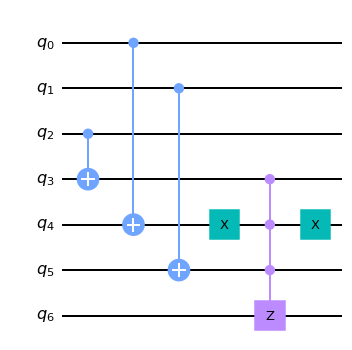

In [44]:
total_qubits = left_rotation.num_qubits + 1
grover_partial_oracle = QuantumCircuit(total_qubits)
grover_partial_oracle.append(left_rotation, range(total_qubits - 1))
grover_partial_oracle.append(comparator, range(total_qubits - comparator.num_qubits, total_qubits))
grover_partial_oracle = grover_partial_oracle.decompose()
grover_partial_oracle.draw()

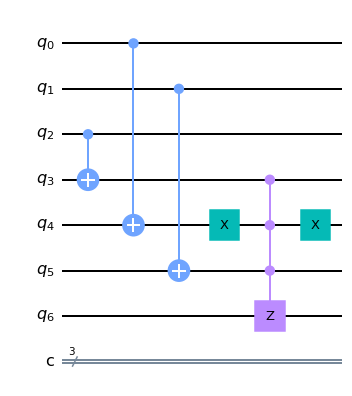

In [45]:
grover_circuit = QuantumCircuit(grover_partial_oracle.num_qubits, n)
grover_circuit.append(grover_partial_oracle.to_gate(), range(grover_partial_oracle.num_qubits))
grover_circuit = grover_circuit.decompose()
grover_circuit.draw()

**Superposition**:

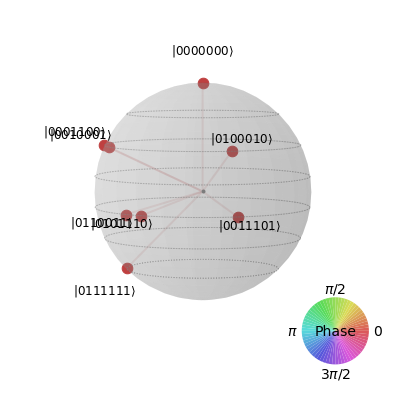

In [46]:
grover_circuit_in_superposition = superposition(grover_circuit, range(n))
plot_state_qsphere(qi.Statevector.from_instruction(grover_circuit_in_superposition))

**Kick-back**:

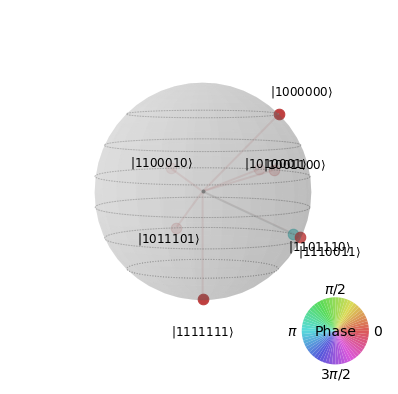

In [47]:
def flip_input(circuit, bit_idx):
    num_qubits, num_clbits = circuit.num_qubits, circuit.num_clbits
    if not num_clbits:
        extension = QuantumCircuit(num_qubits)
    else:
        extension = QuantumCircuit(num_qubits, num_clbits)
    extension.x(bit_idx)
    return extension + circuit

grover_circuit_in_superposition = flip_input(grover_circuit_in_superposition, grover_circuit_in_superposition.num_qubits-1)
plot_state_qsphere(qi.Statevector.from_instruction(grover_circuit_in_superposition))

**Uncompute**:

For this to be a phase oracle, we should compute $|x\rangle\rightarrow(-1)^{f(x)}|x\rangle$. But right now $x$ is entangled with some auxiliar qubits.

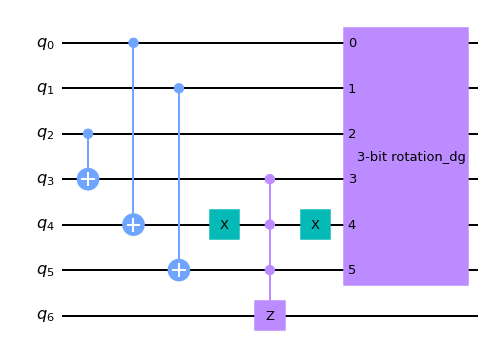

In [48]:
grover_oracle = grover_partial_oracle.copy()
grover_oracle.append(left_rotation.inverse(), range(left_rotation.num_qubits))
grover_oracle.draw()

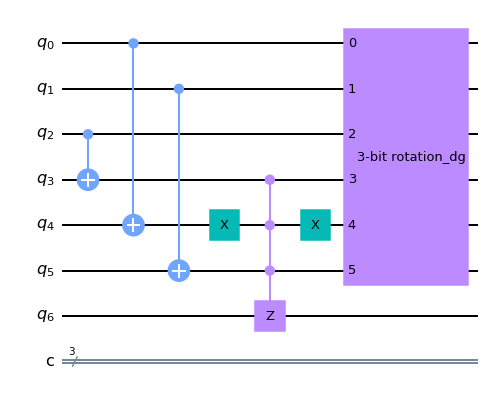

In [49]:
grover_circuit = QuantumCircuit(grover_oracle.num_qubits, n)
grover_circuit.append(grover_oracle.to_gate(), range(grover_oracle.num_qubits))
grover_circuit = grover_circuit.decompose()
grover_circuit.draw()

**Superposition again**

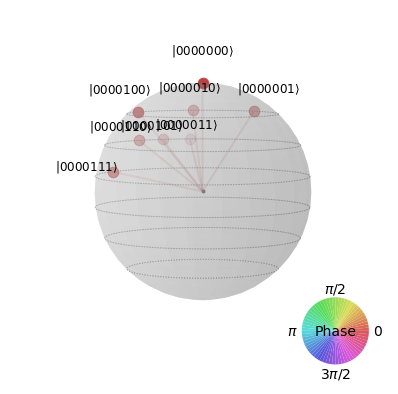

In [50]:
grover_circuit_in_superposition = superposition(grover_circuit, range(n))
plot_state_qsphere(qi.Statevector.from_instruction(grover_circuit_in_superposition))

**Phase kick-back again**

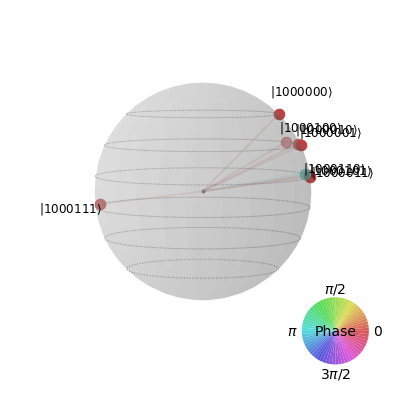

In [51]:
initialized_grover_circuit = flip_input(grover_circuit_in_superposition, grover_circuit_in_superposition.num_qubits-1)
plot_state_qsphere(qi.Statevector.from_instruction(initialized_grover_circuit))

**Grover operator**

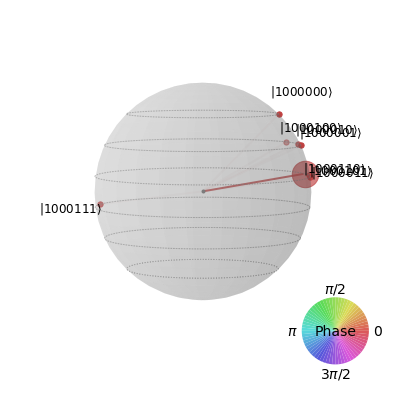

In [52]:
def get_grover_operator(width):
    num_states = 2**width
    matrix_def = np.full(num_states, 2*1/num_states) - np.identity(num_states)
    return qi.Operator(matrix_def)

grover_operator = get_grover_operator(n)
amplified_circuit = initialized_grover_circuit.copy()
amplified_circuit.append(grover_operator, range(n))
plot_state_qsphere(qi.Statevector.from_instruction(amplified_circuit))

**Another iteration**

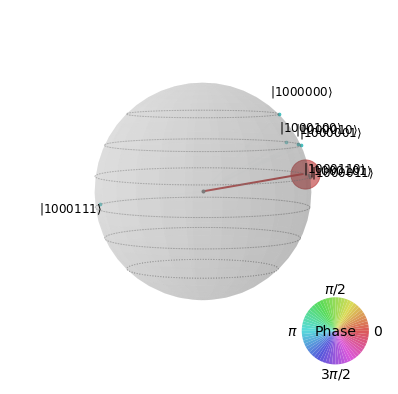

In [53]:
amplified_circuit.append(grover_oracle.to_gate(), range(grover_oracle.num_qubits))
amplified_circuit.append(grover_operator, range(n))
plot_state_qsphere(qi.Statevector.from_instruction(amplified_circuit))

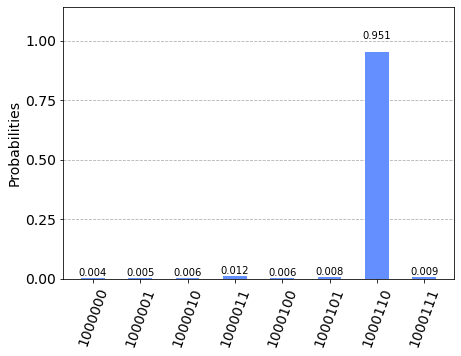

In [54]:
counts = qi.Statevector.from_instruction(amplified_circuit).sample_counts(1024)
plot_histogram(counts)

**Measurement**

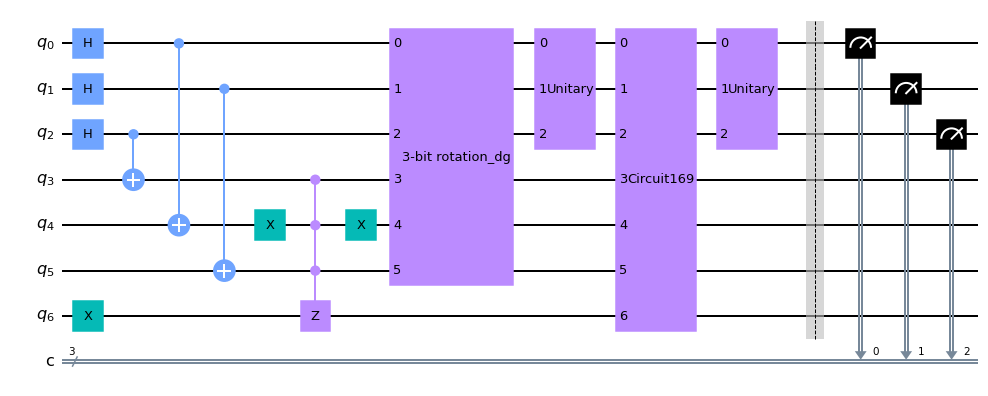

In [55]:
grover_circuit_with_measurement = amplified_circuit.copy()
grover_circuit_with_measurement.barrier()
grover_circuit_with_measurement.measure(range(n), range(n))
grover_circuit_with_measurement.draw()

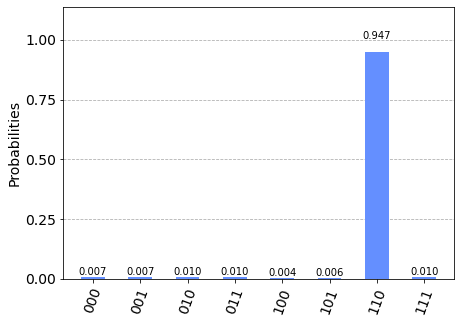

In [56]:
result = execute(grover_circuit_with_measurement, backend=backend).result()
plot_histogram(result.get_counts())